## Audio data preprocessing : Reduce noise and trim silence. 
Procedure :  
    [1] load file  
    [2] reduce noise  
    [3] trim silence  
    [4] output results ( spectogram,fft,audio file,..)   

In [138]:
#Useful packages 
import matplotlib.pyplot as plt
from scipy.io import wavfile
import subprocess
import os
import scipy as sp
from scipy import signal
import math
import numpy as np
import librosa
import librosa.display
import IPython.display as ipd
from scipy.fftpack import fft
from scipy.signal import butter, lfilter
import pandas as pd
from pysndfx import AudioEffectsChain
import python_speech_features

$\bullet$  We are going to test some noise reduction methods on one wav file:  

In [125]:
# path to samples
train_audio_path ='../ALL BIRDS/wavFiles/' 
filename = 'Rose-Crested-Blue-Pipit-364567.wav' 
# generating audio time series and a sampling rate 
samples,sample_rate = librosa.load(str(train_audio_path) + filename)

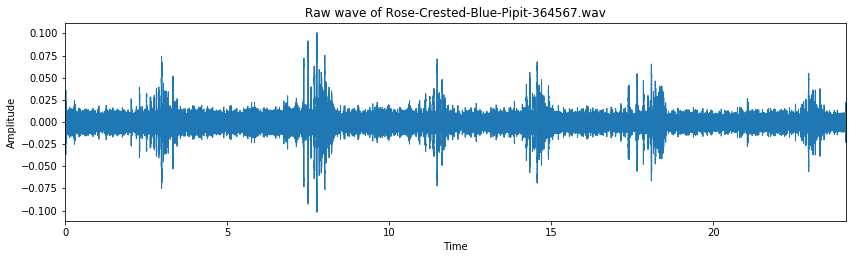

In [126]:
# waveplot 
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
librosa.display.waveplot(samples, sample_rate)
plt.show()


<h4>$\rightarrow$  We can clearly see the noise disturbing the bird call. </h4>

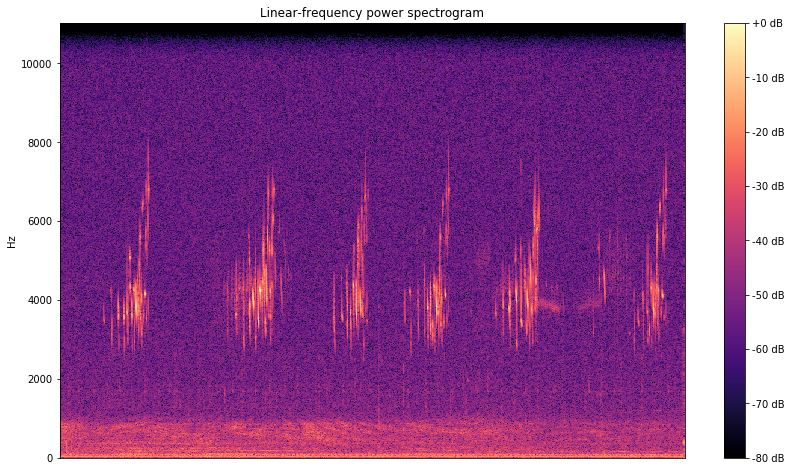

In [127]:
# spectrogram 

fig = plt.figure(figsize=(14, 8))
D = librosa.amplitude_to_db(np.abs(librosa.stft(samples)), ref=np.max)

librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')
plt.show()

<h4> $\rightarrow$ The useful signal (The signal that we are interested in = bird sound) is located between 3000Hz and nearly 6000Hz</h4>

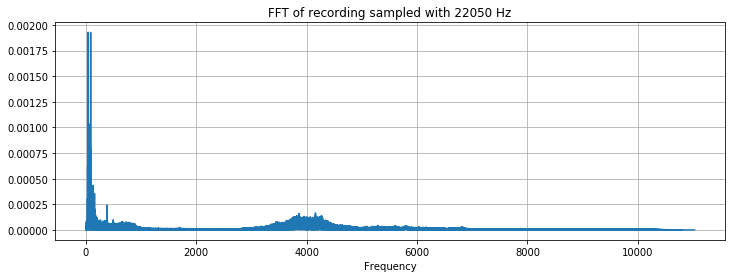

In [128]:
# Fast Fourier Transform graph 
# FFT is simmetrical, so we take just the first half
# FFT is also complex, so we take just the real part (abs)

def custom_fft(y, fs):
    T = 1.0 / fs
    N = y.shape[0]
    yf = np.fft.fft(y)
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    vals = 2.0/N * np.abs(yf[0:N//2])  
    return xf, vals
xf, vals = custom_fft(samples, sample_rate)
plt.figure(figsize=(12, 4))
plt.title('FFT of recording sampled with ' + str(sample_rate) + ' Hz')
plt.plot(xf, vals)
plt.xlabel('Frequency')
plt.grid()
plt.show()

###  Reduce background noise : 

$\rightarrow$ Using predefined methods from "librosa" and "pysndfx" packages.  

In [131]:

#File reader
def read_file(filename):
    
    sample_directory = '../ALL BIRDS/wavFiles/'
    sample_path = sample_directory + filename
    y, sr = librosa.load(sample_path)

    return y, sr

'''------------------------------------
NOISE REDUCTION USING POWER:
------------------------------------'''
def reduce_noise_power(y, sr):

    cent = librosa.feature.spectral_centroid(y=y, sr=sr)

    threshold_h = round(np.median(cent))*1.5
    threshold_l = round(np.median(cent))*0.1

    less_noise = AudioEffectsChain().lowshelf(gain=-30.0, frequency=threshold_l, slope=0.8).highshelf(gain=-12.0, frequency=threshold_h, slope=0.5)#.limiter(gain=6.0)
    y_clean = less_noise(y)

    return y_clean


'''------------------------------------
NOISE REDUCTION USING CENTROID ANALYSIS:
------------------------------------'''

def reduce_noise_centroid_s(y, sr):

    cent = librosa.feature.spectral_centroid(y=y, sr=sr)

    threshold_h = np.max(cent)
    threshold_l = np.min(cent)

    less_noise = AudioEffectsChain().lowshelf(gain=-12.0, frequency=threshold_l, slope=0.5).highshelf(gain=-12.0, frequency=threshold_h, slope=0.5).limiter(gain=6.0)

    y_cleaned = less_noise(y)

    return y_cleaned

def reduce_noise_centroid_mb(y, sr):

    cent = librosa.feature.spectral_centroid(y=y, sr=sr)

    threshold_h = np.max(cent)
    threshold_l = np.min(cent)

    less_noise = AudioEffectsChain().lowshelf(gain=-30.0, frequency=threshold_l, slope=0.5).highshelf(gain=-30.0, frequency=threshold_h, slope=0.5).limiter(gain=10.0)
    y_cleaned = less_noise(y)


    cent_cleaned = librosa.feature.spectral_centroid(y=y_cleaned, sr=sr)
    columns, rows = cent_cleaned.shape
    boost_h = math.floor(rows/3*2)
    boost_l = math.floor(rows/6)
    boost = math.floor(rows/3)


    boost_bass = AudioEffectsChain().lowshelf(gain=16.0, frequency=boost_h, slope=0.5)#.lowshelf(gain=-20.0, frequency=boost_l, slope=0.8)
    y_clean_boosted = boost_bass(y_cleaned)

    return y_clean_boosted


'''------------------------------------
NOISE REDUCTION USING MFCC:
------------------------------------'''
def reduce_noise_mfcc_down(y, sr):

    hop_length = 512


    ## mfcc
    mfcc = python_speech_features.base.mfcc(y)
    mfcc = python_speech_features.base.logfbank(y)
    mfcc = python_speech_features.base.lifter(mfcc)

    sum_of_squares = []
    index = -1
    for r in mfcc:
        sum_of_squares.append(0)
        index = index + 1
        for n in r:
            sum_of_squares[index] = sum_of_squares[index] + n**2

    strongest_frame = sum_of_squares.index(max(sum_of_squares))
    hz = python_speech_features.base.mel2hz(mfcc[strongest_frame])

    max_hz = max(hz)
    min_hz = min(hz)

    speech_booster = AudioEffectsChain().highshelf(frequency=min_hz*(-1)*1.2, gain=-12.0, slope=0.6).limiter(gain=8.0)
    y_speach_boosted = speech_booster(y)

    return (y_speach_boosted)

def reduce_noise_mfcc_up(y, sr):

    hop_length = 512


    ## mfcc
    mfcc = python_speech_features.base.mfcc(y)
    mfcc = python_speech_features.base.logfbank(y)
    mfcc = python_speech_features.base.lifter(mfcc)

    sum_of_squares = []
    index = -1
    for r in mfcc:
        sum_of_squares.append(0)
        index = index + 1
        for n in r:
            sum_of_squares[index] = sum_of_squares[index] + n**2

    strongest_frame = sum_of_squares.index(max(sum_of_squares))
    hz = python_speech_features.base.mel2hz(mfcc[strongest_frame])

    max_hz = max(hz)
    min_hz = min(hz)

    speech_booster = AudioEffectsChain().lowshelf(frequency=min_hz*(-1), gain=12.0, slope=0.5)#.highshelf(frequency=min_hz*(-1)*1.2, gain=-12.0, slope=0.5)#.limiter(gain=8.0)
    y_speach_boosted = speech_booster(y)

    return (y_speach_boosted)

'''------------------------------------
NOISE REDUCTION USING MEDIAN:
------------------------------------'''

def reduce_noise_median(y, sr):
    y = sp.signal.medfilt(y,3)
    return (y)




##### SILENCE TRIMMER: returns an audio matrix with less silence and the amout of time that was trimmed

def trim_silence(y):
    y_trimmed, index = librosa.effects.trim(y, top_db=20, frame_length=2, hop_length=500)
    trimmed_length = librosa.get_duration(y) - librosa.get_duration(y_trimmed)

    return y_trimmed, trimmed_length


###################### TEST ##################

filename = 'Rose-Crested-Blue-Pipit-364567.wav'


y, sr = read_file(filename)

# reducing noise 
y_reduced_power = reduce_noise_power(y, sr)
y_reduced_centroid_s = reduce_noise_centroid_s(y, sr)
y_reduced_centroid_mb = reduce_noise_centroid_mb(y, sr)
y_reduced_mfcc_up = reduce_noise_mfcc_up(y, sr)
y_reduced_mfcc_down = reduce_noise_mfcc_down(y, sr)
y_reduced_median = reduce_noise_median(y, sr)

# trimming silences
y_reduced_power, time_trimmed1 = trim_silence(y_reduced_power)

y_reduced_centroid_s, time_trimmed2 = trim_silence(y_reduced_centroid_s)

y_reduced_centroid_mb, time_trimmed3 = trim_silence(y_reduced_centroid_mb)

y_reduced_mfcc_up, time_trimmed4 = trim_silence(y_reduced_mfcc_up)

y_reduced_mfcc_down, time_trimmed5 = trim_silence(y_reduced_mfcc_down)

y_reduced_median, time_trimmed6 = trim_silence(y_reduced_median)



### Visualize results : 
#### Example : Noise reduction using power : 

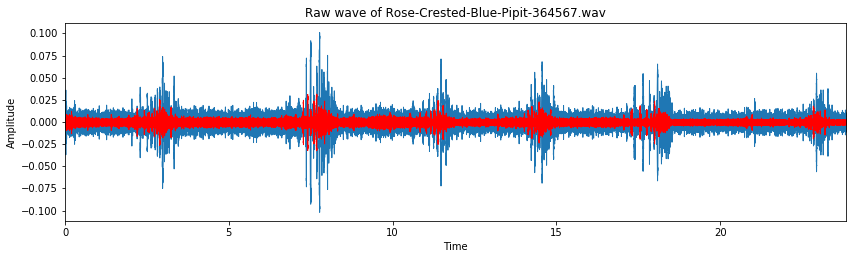

In [133]:
### superimpose waveplots
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
librosa.display.waveplot(y, sr)
librosa.display.waveplot(   y_reduced_power, sr, color='r')
plt.show()

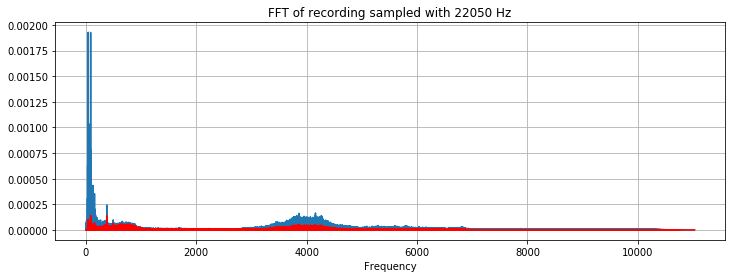

In [134]:
### superimpose FFT plots
xf, vals = custom_fft(   y_reduced_power,sr)
xf_old, vals_old = custom_fft(y,sr)
plt.figure(figsize=(12, 4))
plt.title('FFT of recording sampled with ' + str(sr) + ' Hz')

plt.plot(xf_old, vals_old)
plt.plot(xf, vals, color='r')
plt.xlabel('Frequency')
plt.grid()
plt.show()

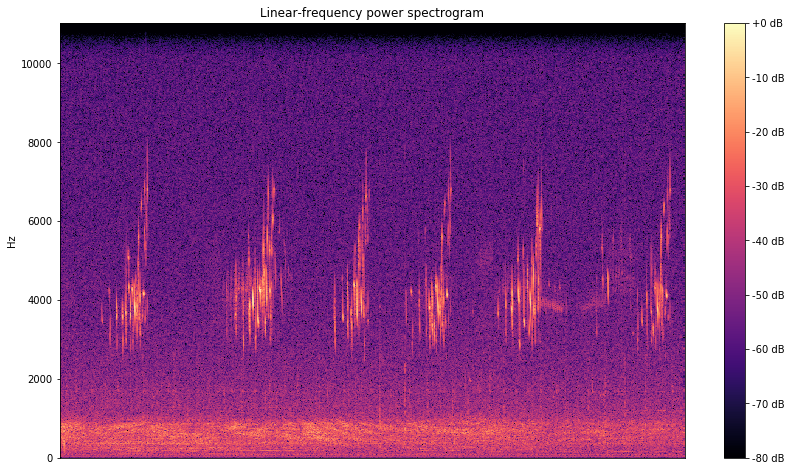

In [135]:
### spectrogram for the new audio time series
fig = plt.figure(figsize=(14, 8))
D = librosa.amplitude_to_db(np.abs(librosa.stft(y_reduced_power)), ref=np.max)

librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')
plt.show()

<h4> $\rightarrow$  We can notice that the filter reduced the amplitude of the signal, but did not cancel the noise. We can make sure of it while checking the new spectrogram wich is similar to the real one and also by playing the 2 audio files. </h4>

In [136]:
# Before filtering
ipd.Audio(y, rate=sr)

In [137]:
## After filtering
ipd.Audio( y_reduced_power, rate=sr)

###  Reduce background noise : 

$\rightarrow$ By implementing a Band-pass filter.  

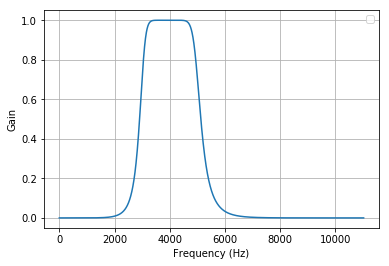

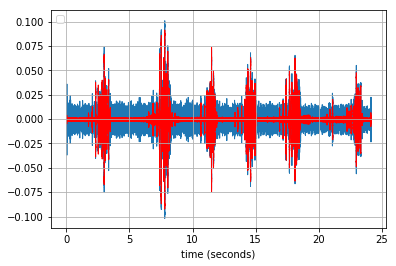

In [141]:



def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import freqz

# Sample rate and desired cutoff frequencies (in Hz).
fs = sample_rate

lowcut = 3000 ## manually through the spectrogam 
highcut = 5000 ## manually
### --> to need to find a way how to get lowcut and highcut freguencies automatically 


# Plot the frequency response. 
plt.figure(1)
plt.clf()
b, a = butter_bandpass(lowcut, highcut, fs)
w, h = freqz(b, a, worN=2000)
plt.plot((fs * 0.5 / np.pi) * w, abs(h))

plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.grid(True)
plt.legend(loc='best')
plt.show()

### superimpose waveplots for filtred and real signal 
y_filtered = butter_bandpass_filter(y, lowcut, highcut, fs, order=5)
librosa.display.waveplot(y,fs)
librosa.display.waveplot(y_filtered,fs,color='r')
plt.xlabel('time (seconds)')

plt.grid(True)
plt.axis('tight')
plt.legend(loc='upper left')
plt.show()

<h4> $\rightarrow$Here the results are better, the background noise is canceled , the amplitude of useful signal is maintained.</h4>

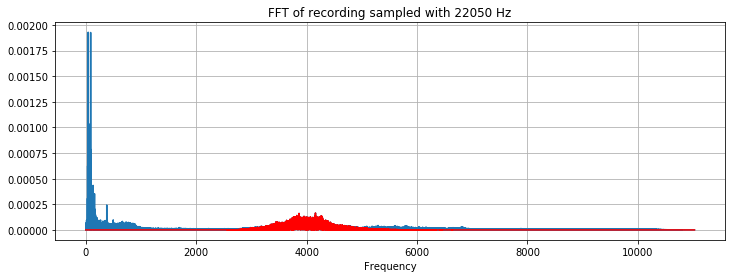

In [142]:
### superimpose FFT plots for filtred and real signal 
xf, vals = custom_fft(y_filtered, sample_rate)
xf_old, vals_old = custom_fft(y, sample_rate)
plt.figure(figsize=(12, 4))
plt.title('FFT of recording sampled with ' + str(sample_rate) + ' Hz')
plt.plot(xf_old, vals_old)
plt.plot(xf, vals, color='r')
plt.xlabel('Frequency')
plt.grid()
plt.show()

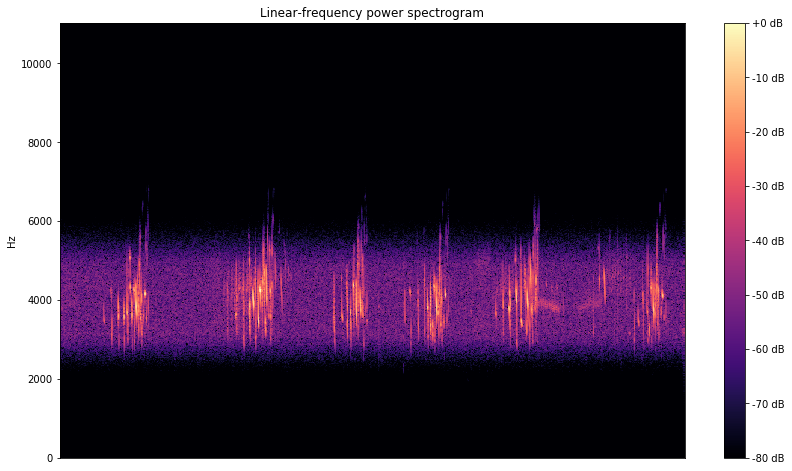

In [143]:
fig = plt.figure(figsize=(14, 8))
D = librosa.amplitude_to_db(np.abs(librosa.stft(y_filtered)), ref=np.max)

librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')
plt.show()

<h4> $\rightarrow$ Once the filter is applied, we can notice a change in the spectrogram and only the useful part of the signal is present while the noise disappeared.  
<br>


<h4> $\rightarrow$ To make sure that the noise is canceled, we can verify it by listening to the 2 audios </h4>

In [145]:
#real signal
ipd.Audio(y, rate=sr)

In [147]:
# filtered signal 
ipd.Audio(y_filtered, rate=sr)

<h4> $\rightarrow$ One of the consequences of denoising is that it leaves some silent parts in the audio.In order to remove it we use trimming.  </h4>

In [148]:
y_filtered_trimmed, time_trimmed = trim_silence(y1)

In [149]:
ipd.Audio(y_filtered_trimmed, rate=sr)

In [152]:
print (str(time_trimmed)+ " s")

3.0862585034 s
